# Setup Steps

In [1]:
#!pip install pycryptodome
#!pip install pandas
#!pip install anonsdk_dir-1.0.0-py3-none-any.whl

In [2]:
# Surpress warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import libraries
import time
import warnings
import os
import json
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import anonsdk as asdk
import datetime

# Authentication (Anonymization Engine + API Playground)

In [4]:
# Function to authenticate with the Playground
def get_jwt_token(email, password):
    """Logs in to get the JWT token."""
    login_url = 'https://api.playground.protegrity.com/auth/login'
    login_payload = {
        "email": email,
        "password": password
    }
    login_headers = {
        'Content-Type': 'application/json'
    }
    login_response = requests.post(login_url, headers=login_headers, data=json.dumps(login_payload))
    if login_response.status_code == 201:
        jwt_token = login_response.json().get('jwt_token')
        print("Login successful, JWT token obtained.")
        return jwt_token
    else:
        print(f"Failed to login. Status code: {login_response.status_code}")
        print(login_response.text)
        return None

In [5]:
# API Playground Creds 
# REPLACE WITH YOUR OWN
# SIGNUP ON https://protegrity.com/api-playground
email = "your_email"
password = "your_password"
jwt = jwt_token = get_jwt_token(email, password)
api_key = "your_group_api_key"

Login successful, JWT token obtained.


In [6]:
# Connect to Anon service
ann_cluster = asdk.Connection('https://anon.playground.protegrity.com:443', api_key=api_key, jwt=jwt)


In [7]:
# Function to visualize Risk & Utility metrics
def display_risk_utility(riskmetrics, utilitymetrics):

    utilitymetrics2 = utilitymetrics.copy(deep=True)
    riskmetrics2 = riskmetrics.copy(deep=True)

    def convert(x):
        return np.round(x * 100, 1)

    riskmetrics2[['journalist', 'marketer', 'prosecutor']] = riskmetrics2[['journalist', 'marketer', 'prosecutor']].apply(convert, axis=1)
    
    utilitymetrics2[['Source', 'Result']] = utilitymetrics2[['Source', 'Result']].apply(convert, axis=1)

    # Risk metrics
    def display_subset(riskmetrics, risk_model):
        
        subset = riskmetrics.copy(deep=True)
        subset = subset[[risk_model, 'type']]
        
        subset.rename(columns={'type': 'Protegrity Anonymization'}, inplace=True)
        subset = subset.pivot(columns='Protegrity Anonymization')[risk_model]
        subset.rename(columns={'Result': 'After', 'Source': 'Before'}, inplace=True)

        subset.index.names = ['Metric']
        subset = subset[['Before', 'After']]
        
        ax = subset.plot.bar(rot=25, color=["#DADCE2", "#FA5A25"], figsize=(15, 7), title=f"Risk metrics for the {risk_model} model")

        for p in ax.patches:
            ax.annotate(
                f"{p.get_height()}%", (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points'
            )    
            
    display_subset(riskmetrics=riskmetrics2, risk_model='prosecutor')
    display_subset(riskmetrics=riskmetrics2, risk_model='journalist')
    display_subset(riskmetrics=riskmetrics2, risk_model='marketer')

    # Utility metrics    
    utilitymetrics2.rename(columns={'Source': 'Before', 'Result': 'After'}, inplace=True)
    
    ax = utilitymetrics2.plot.bar(rot=25, color=["#DADCE2", "#FA5A25"], figsize=(15, 7), title='Utility metrics')

    for p in ax.patches:
        ax.annotate(
            f"{p.get_height()}%", (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points'
        )
        

# Data Exploration & Preparation

In [8]:
data = pd.read_csv('banking_us_customers.csv',sep=",")

In [9]:
# OPTIONAL
# Explore the dataset metadata
data.dtypes

Customer_ID          object
ZIP_Code              int64
Age                   int64
Income                int64
Monthly_Spending    float64
Credit_Score          int64
Loan_Amount         float64
Savings_Balance     float64
Investment_Value    float64
customer_since       object
gender               object
marital_status       object
employment_type      object
education_level      object
dtype: object

In [10]:
# OPTIONAL
# View top 10 rows
data.head(10)

Customer_ID  ZIP_Code  Age  Income  Monthly_Spending  Credit_Score  \
0   CUST00000     97284   56   97447       1456.180871           715   
1   CUST00001      1664   69   56444       1576.358950           683   
2   CUST00002     59775   46  465350      14352.799740           200   
3   CUST00003      6536   32   62499       1754.334125           635   
4   CUST00004     51719   60   56117        284.143214           751   
5   CUST00005     25794   25   72197       1451.345906           715   
6   CUST00006     81206   78   76849        745.289043           712   
7   CUST00007     19501   38  108230       1362.136374           624   
8   CUST00008     46171   56   76390       1438.105206           765   
9   CUST00009     81628   75   73865       1988.074179           679   

    Loan_Amount  Savings_Balance  Investment_Value customer_since  gender  \
0   8596.023209     16991.032776      34053.283289     10-09-2015  Female   
1   6827.045391     28025.677876      34804.048571     02-01-2020    Male   
2  73477.763400    142336.205686      95509.483729     31-01-2011    Male   
3  15062.845249     27957.538613      17484.186124     26-05-2013    Male   
4   9341.763858     32537.316031      10368.640109     14-06-2014  Female   
5    102.302454     35679.671452      52823.423677     13-11-2024  Female   
6  13889.811264     14909.344906      13304.496414     22-10-2023    Male   
7  16212.546831     17780.910471      20704.115922     15-02-2007  Female   
8  12665.672014     39307.516897      20134.941670     20-02-2025    Male   
9  14592.055102      1847.644637       2119.144950     20-02-2025    Male   

  marital_status employment_type education_level  
0        Widowed   Self-employed     High School  
1        Married       Full-time     High School  
2       Divorced       Executive        Master's  
3       Divorced       Full-time      Bachelor's  
4        Married       Full-time     High School  
5         Single       Full-time      Bachelor's  
6       Divorced       Full-time     High School  
7       Divorced       Full-time        Master's  
8        Married       Full-time        Master's  
9        Married       Full-time     High School

In [11]:
# REQUIRED IF RUNNING DATE GENERALIZATION
# Convert string to datetime
specific_time = datetime.time(12, 0, 0) # 12:00:00
data["customer_since"] = pd.to_datetime(data["customer_since"], format='%d-%m-%Y', errors='coerce')
data["customer_since"] = data['customer_since'].apply(lambda x: datetime.datetime.combine(x, specific_time))


In [12]:
# OPTIONAL
# Explore the categorical variables
gender = data['gender'].unique()
marital_status = data['marital_status'].unique()
education_level = data['education_level'].unique()
employment_type = data['employment_type'].unique()
categories = [gender, marital_status,education_level, employment_type]
categories

[array(['Female', 'Male'], dtype=object),
 array(['Widowed', 'Married', 'Divorced', 'Single'], dtype=object),
 array(['High School', "Master's", "Bachelor's", 'Doctorate'], dtype=object),
 array(['Self-employed', 'Full-time', 'Executive', 'Student', 'Unemployed',
        'Part-time'], dtype=object)]

In [13]:
# OPTIONAL
# Explore the continuous variables 
data.describe()

ZIP_Code          Age         Income  Monthly_Spending  \
count   1000.00000  1000.000000    1000.000000       1000.000000   
mean   49178.03000    49.857000   73966.931000       1618.234100   
min      685.00000    18.000000   10000.000000        100.000000   
25%    23011.50000    35.000000   57484.500000       1189.232363   
50%    48257.50000    50.000000   71833.500000       1542.042571   
75%    73587.25000    66.000000   85736.500000       1884.193245   
max    99876.00000    79.000000  554915.000000      19745.557210   
std    28659.40733    18.114267   38566.963794       1175.054243   

       Credit_Score    Loan_Amount  Savings_Balance  Investment_Value  \
count   1000.000000    1000.000000      1000.000000       1000.000000   
mean     675.285000   16879.161773     19921.031345      29921.759261   
min      200.000000      21.865435         0.000000          0.000000   
25%      646.000000    8961.730403      7377.817864      12241.335343   
50%      680.500000   15149.274866     18999.775161      27708.266064   
75%      713.250000   22115.301188     28666.410587      43242.834499   
max      843.000000  247277.439663    234170.369146     288179.853139   
std       69.301937   16385.480169     17435.921945      25606.270171   

                      customer_since  
count                           1000  
mean   2016-11-26 15:25:55.200000256  
min              2005-06-16 12:00:00  
25%              2012-04-21 00:00:00  
50%              2017-05-27 12:00:00  
75%              2021-11-25 12:00:00  
max              2025-06-11 12:00:00  
std                              NaN

# Job Configuration

In [36]:
# JOB CONFIGURATION

# IMPORTANT – LIMITED VERSION OF THE PRODUCT
# The job configuration supports only 5 attribute transformations. 
# More attributes will cause the job to fail

# Connect to the Anonymization Cluster
# Create a Dataset Object
e = asdk.AnonElement(ann_cluster, data, pty_storage=False)

# Set K for the dataset
e.config.k = asdk.K(2)

# Fields to preserve as is
preserved_list = ['Credit_Score']
e.assign(preserved_list, asdk.Preserve())

# Fields to redact
e['Customer_ID'] = asdk.Redact()

# Generalize Age and Weight
#e["Monthly_Spending"] = asdk.Gen_Interval(['1000', '2000'])
#e["Savings_Balance"] = asdk.Gen_Interval(['1000', '10000'])
e["Investment_Value"] = asdk.Gen_Interval(['1000', '10000'])

e["Age"] = asdk.Gen_Interval(['5', '10'], importance = 0.8)

# Employment Tree Gen
employmentTree = {
  'lvl0': ['Self-employed', 'Full-time', 'Executive', 'Student', 'Unemployed', 'Part-time'],
  'lvl1': ["Self-employed", "Employed", "Employed", "Unemployed", "Unemployed", "Employed"],
  'lvl2': ["Employed", "Employed", "Employed", "Unemployed", "Unemployed", "Employed"],
}

e['employment_type'] = asdk.Gen_Tree(pd.DataFrame(data=employmentTree), importance = 0.2)
#e["employment_type"] = asdk.LDiv(lfactor=3)

# Micro-aggregation
e["Income"] = asdk.MicroAgg(asdk.AggregateFunction.Mean, importance=0.2)

# L-Diversity 
# Make sure there are at least 2 different sensitive values per record
e["gender"] = asdk.LDiv(lfactor=2)

# Generalize Date
#['H.M.S.ms', 'H.M.S', 'H.M', 'H', 'WD.M.Y', 'W.M.Y', 'FD.M.Y', 'M.Y', 'QTR.Y', 'Y', 'DEC', 'CEN']
#e['customer_since'] = asdk.Gen_Rounding(["M.Y", "Y"], importance=0.2)

# Mask Characters
#e['citizenSince'] = asdk.Gen_Mask(maskchar="*")

# Max suppresion 
# I.e. maximum allowed fraction of records removed from the dataset to achieve the set privacy goals
e.config['maxSuppression'] = 0.5

# Explore the dataset and transformation metadata
e.describe()


DataFrame Columns:Index(['Customer_ID', 'ZIP_Code', 'Age', 'Income', 'Monthly_Spending',
       'Credit_Score', 'Loan_Amount', 'Savings_Balance', 'Investment_Value',
       'customer_since', 'gender', 'marital_status', 'employment_type',
       'education_level'],
      dtype='object')
Attribute Config:
Customer_ID object Direct Identifier attribute.
ZIP_Code int64 Ignored attribute.
Age int64 Interval based with levels [['5', '10']]. Having lower bound [18] and upper bound [79] and importance [0.8]
Income int64 Micro-Aggregation [Mean]
Monthly_Spending float64 Ignored attribute.
Credit_Score int64 Non-Sensitive attribute.
Loan_Amount float64 Ignored attribute.
Savings_Balance float64 Ignored attribute.
Investment_Value float64 Interval based with levels [['1000', '10000']]. Having lower bound [0.0] and upper bound [288179.8531389654] and importance [0.5]
customer_since datetime64[ns] Ignored attribute.
gender object  Sensitive data. L-Diversity with l factor of [2]
marital_status obje

## Job Run

In [37]:
# JOB RUN
job = asdk.anonymize(e, pty_storage=False)

In [38]:
job.status()

{'completed': None,
 'id': '96786005-2df3-4ee9-b0cf-e77be434166c',
 'info': None,
 'running': None,
 'status': 'InQueue'}

In [39]:
job.result().df.head(10)

Age  Credit_Score     Investment_Value  gender employment_type  \
0  30 - 39           635  17000.00 - 17999.99    Male       Full-time   
1  70 - 79           712  13000.00 - 13999.99    Male       Full-time   
2  70 - 79           679    2000.00 - 2999.99    Male       Full-time   
3  30 - 39           716        0.00 - 999.99    Male       Full-time   
4  40 - 49           539    3000.00 - 3999.99    Male       Full-time   
5  70 - 79           709  28000.00 - 28999.99  Female       Full-time   
6  50 - 59           707  27000.00 - 27999.99    Male       Full-time   
7  40 - 49           668        0.00 - 999.99  Female       Full-time   
8  50 - 59           610  27000.00 - 27999.99    Male       Full-time   
9  70 - 79           666  37000.00 - 37999.99  Female       Full-time   

  Customer_ID        Income  
0           *  65470.750000  
1           *  55205.000000  
2           *  65445.500000  
3           *  73903.333333  
4           *  65990.000000  
5           *  59681.200000  
6           *  73164.666667  
7           *  63152.090909  
8           *  73164.666667  
9           *  84324.833333

# Job Results

## Risk & Utility Measurements (Run #1; k = 2)

In [18]:
job.riskStat().iloc[[0,1,3,4]]

journalist  marketer  prosecutor    type
avgRecordIdentification           0.9620    0.9620      0.9620  Source
maxProbabilityIdentification      1.0000    0.0000      1.0000  Source
avgRecordIdentification           0.2775    0.2775      0.2775  Result
maxProbabilityIdentification      0.5000    0.0000      0.5000  Result

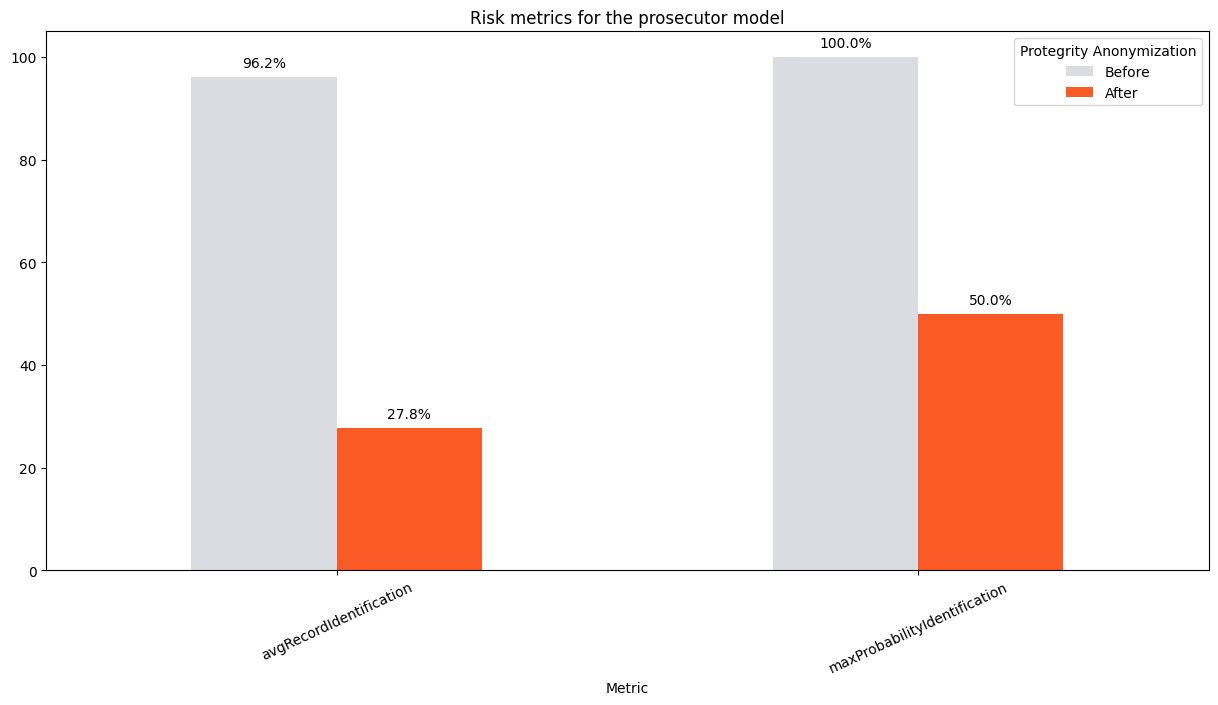

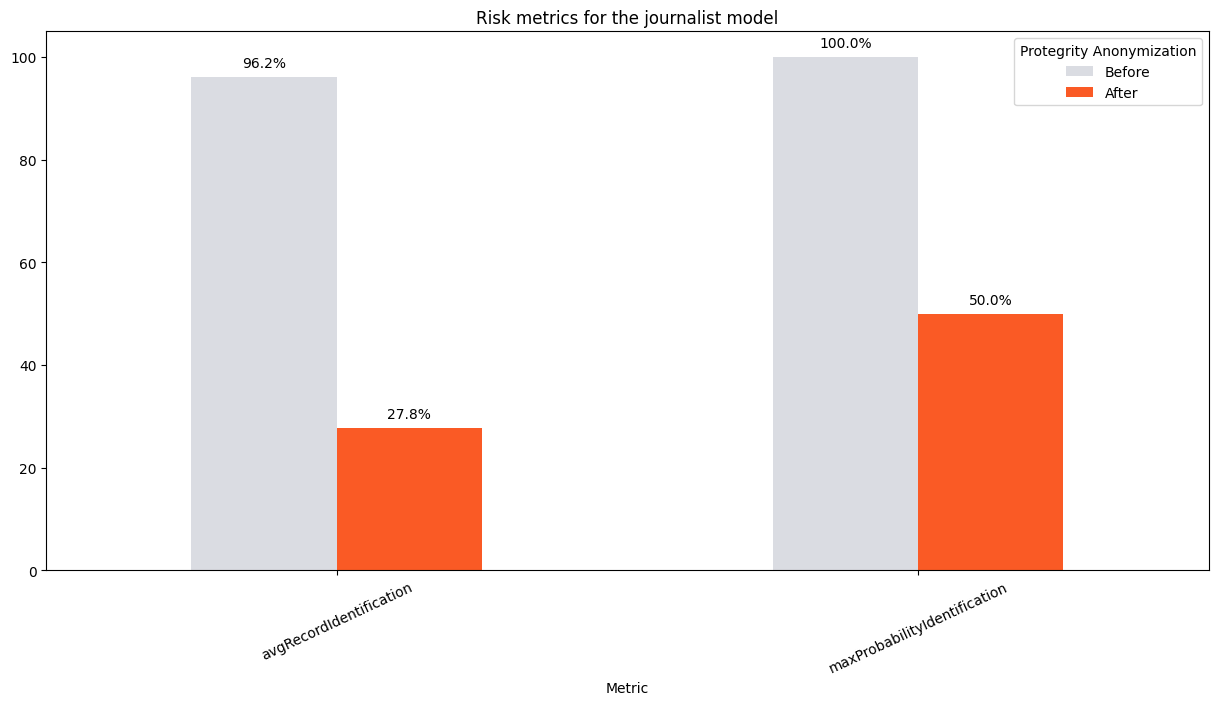

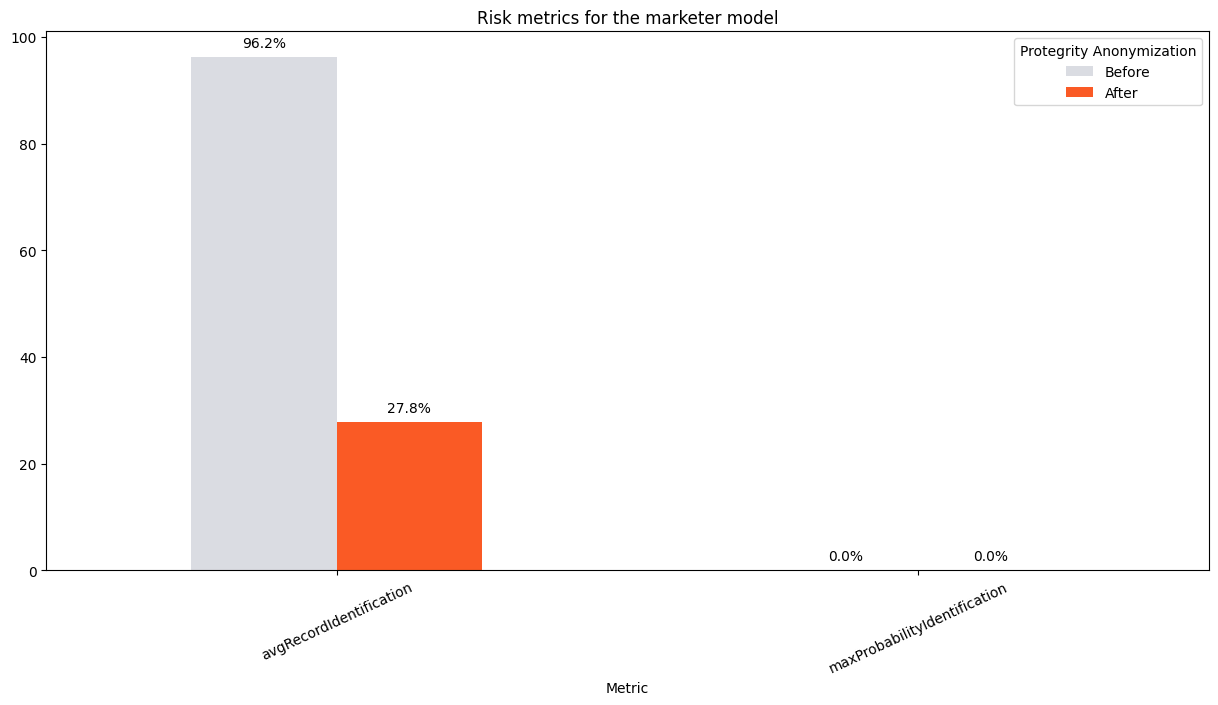

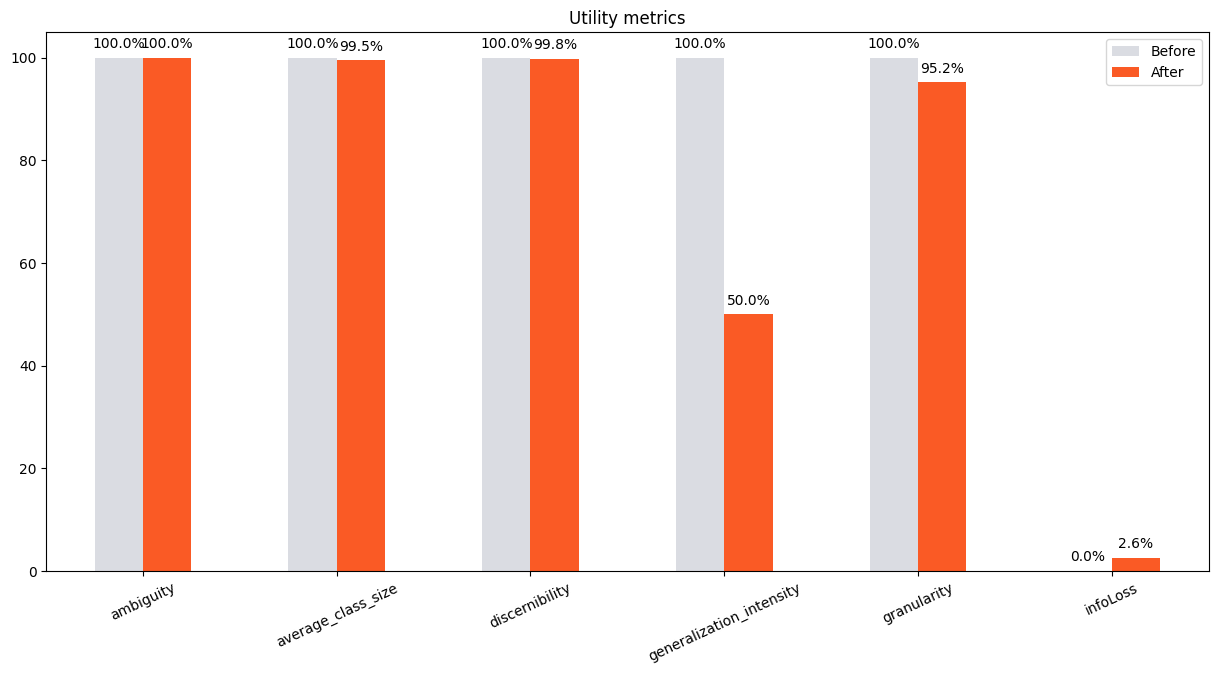

In [19]:
display_risk_utility(riskmetrics=job.riskStat().iloc[[0,1,3,4]], utilitymetrics=job.utilityStat())


## Risk & Utility Measurements (Run #2; k = 4)

In [26]:
job.riskStat().iloc[[0,1,3,4]]

journalist  marketer  prosecutor    type
avgRecordIdentification           0.9620    0.9620      0.9620  Source
maxProbabilityIdentification      1.0000    0.0000      1.0000  Source
avgRecordIdentification           0.0664    0.0664      0.0664  Result
maxProbabilityIdentification      0.2500    0.0000      0.2500  Result

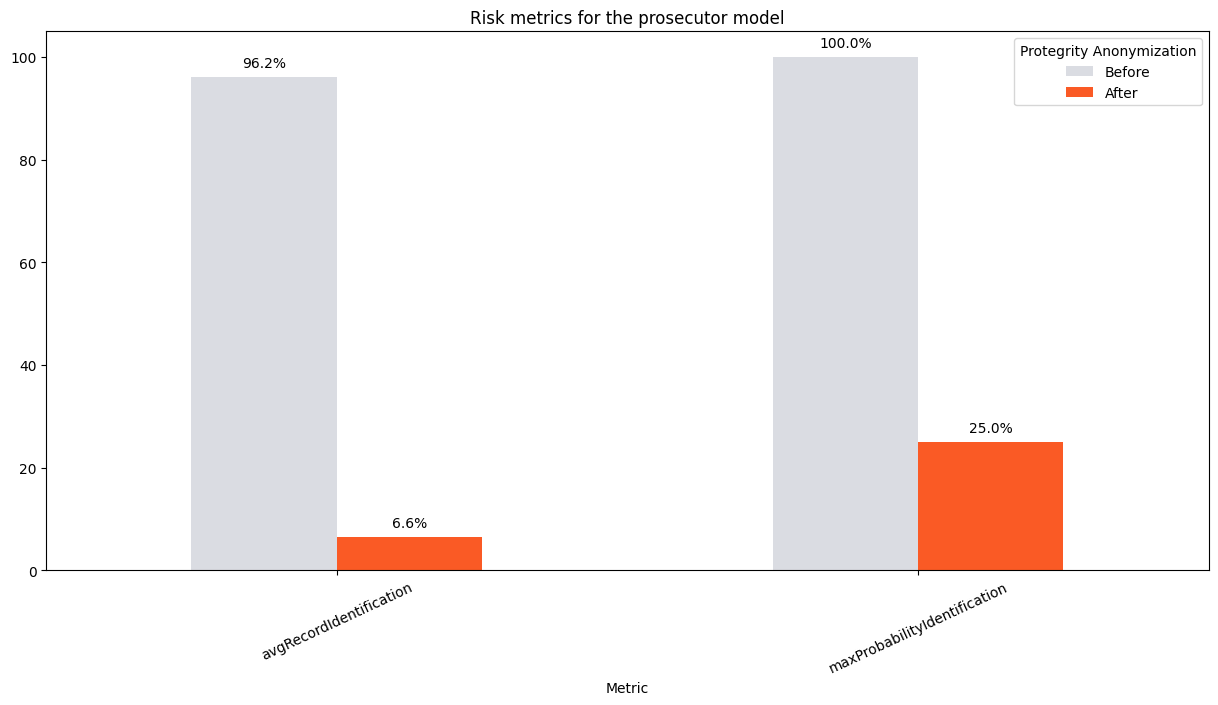

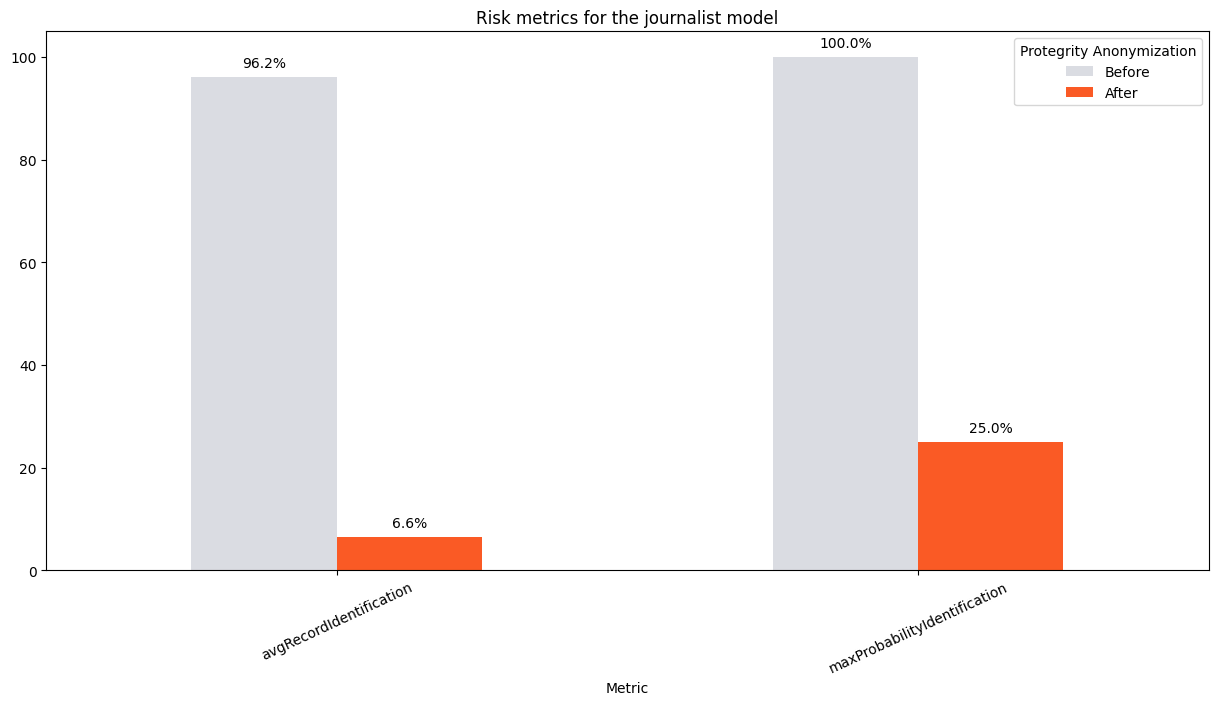

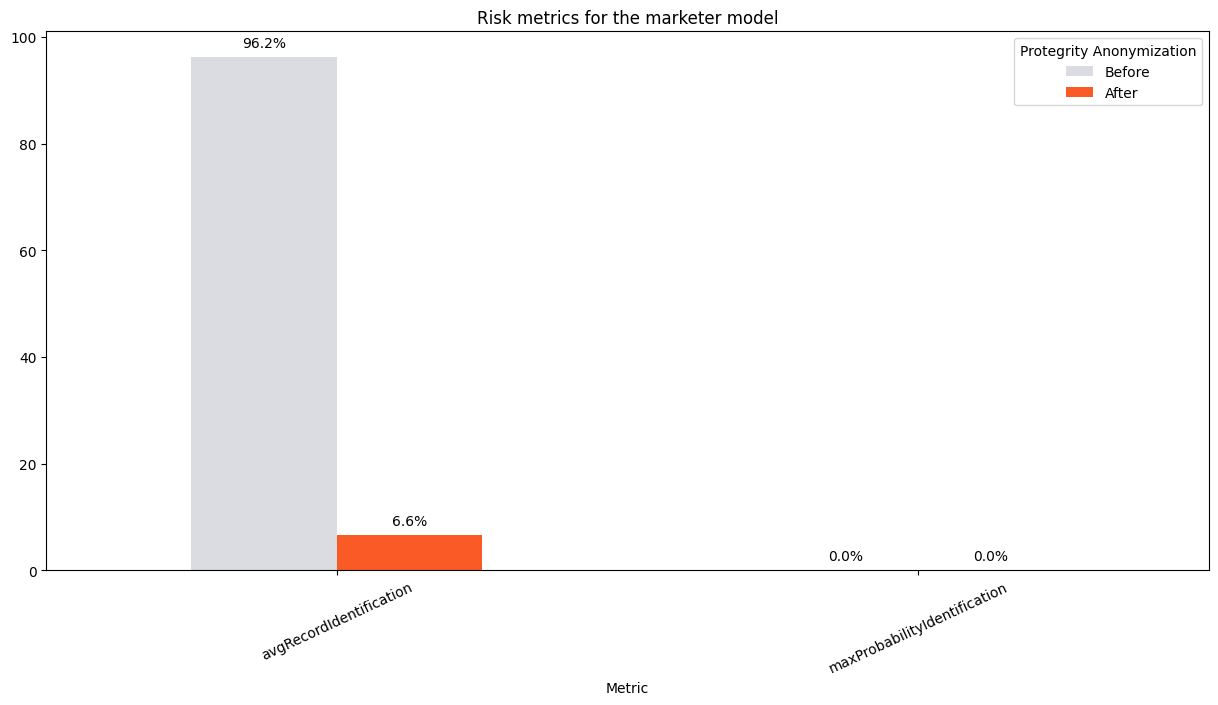

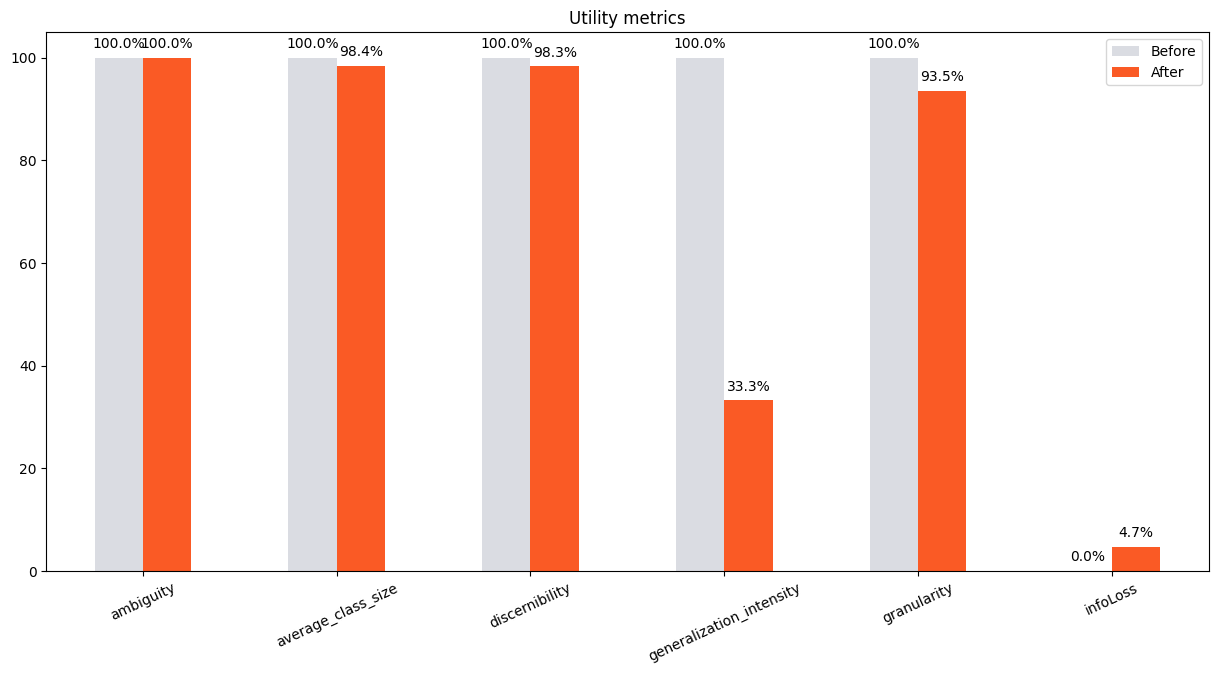

In [27]:
display_risk_utility(riskmetrics=job.riskStat().iloc[[0,1,3,4]], utilitymetrics=job.utilityStat())


## Risk & Utility Measurements (Run #3; k = 4; l = 3 [employment])

In [32]:
job.riskStat().iloc[[0,1,3,4]]

journalist  marketer  prosecutor    type
avgRecordIdentification           0.9480    0.9480      0.9480  Source
maxProbabilityIdentification      1.0000    0.0000      1.0000  Source
avgRecordIdentification           0.0402    0.0402      0.0402  Result
maxProbabilityIdentification      0.1667    0.0000      0.1667  Result

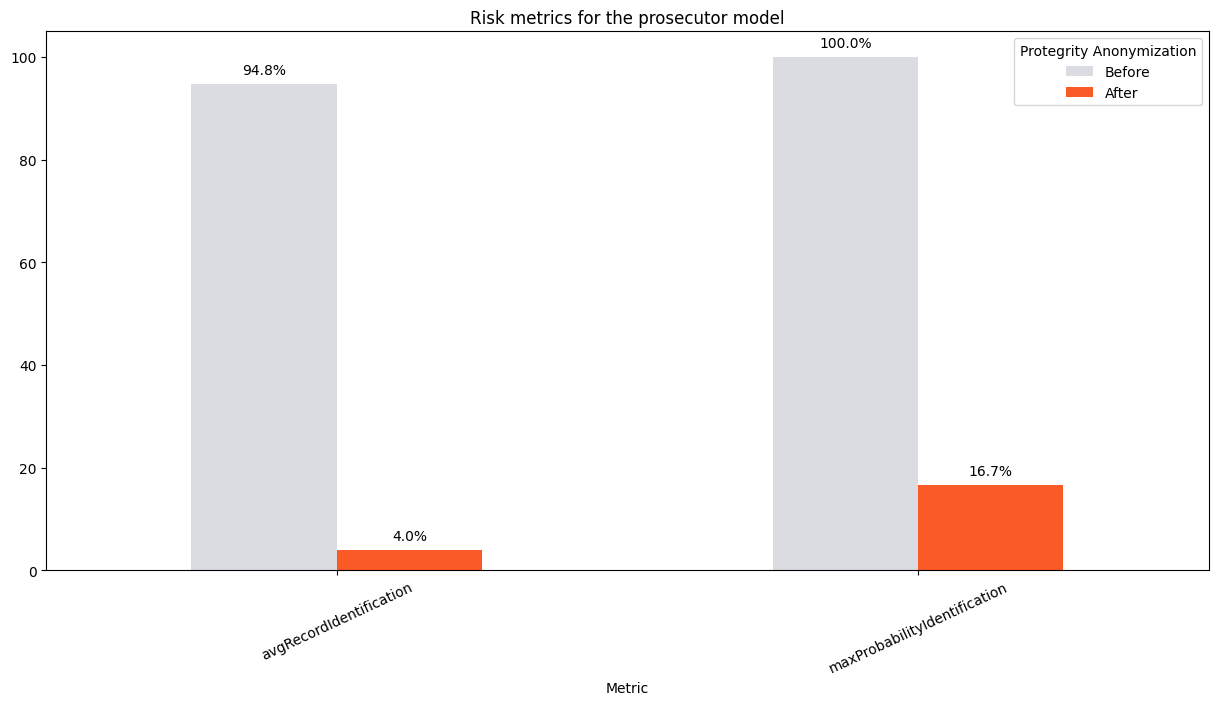

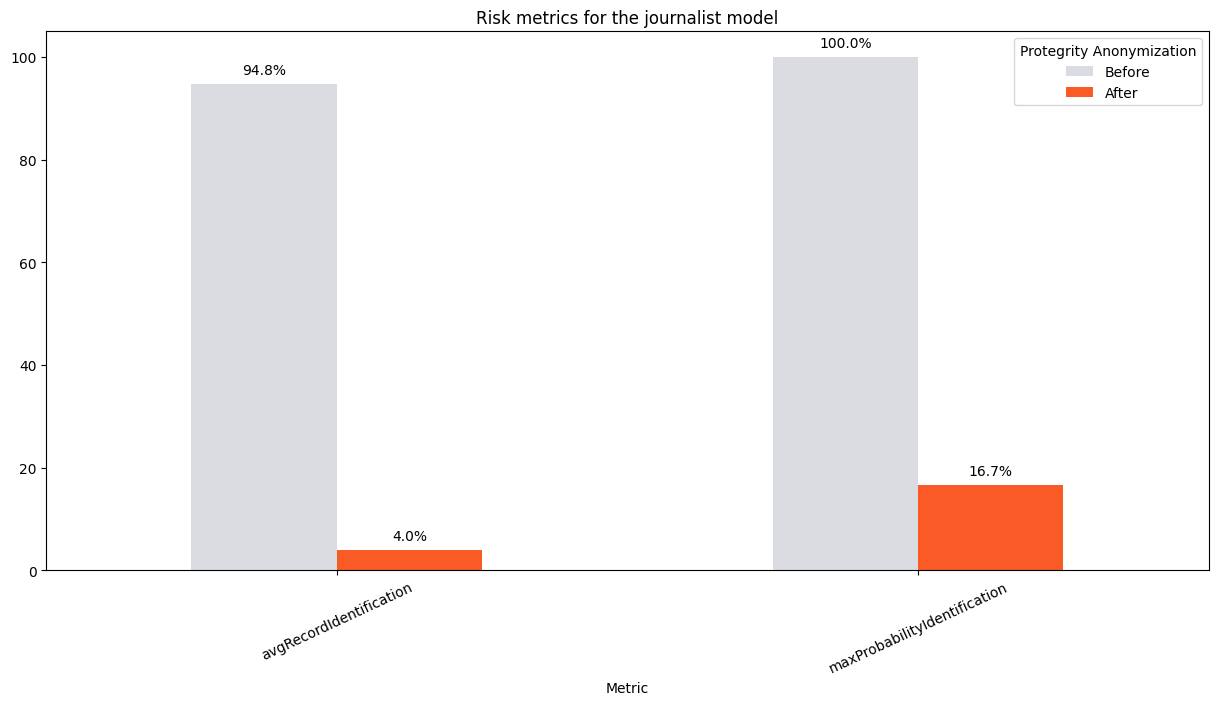

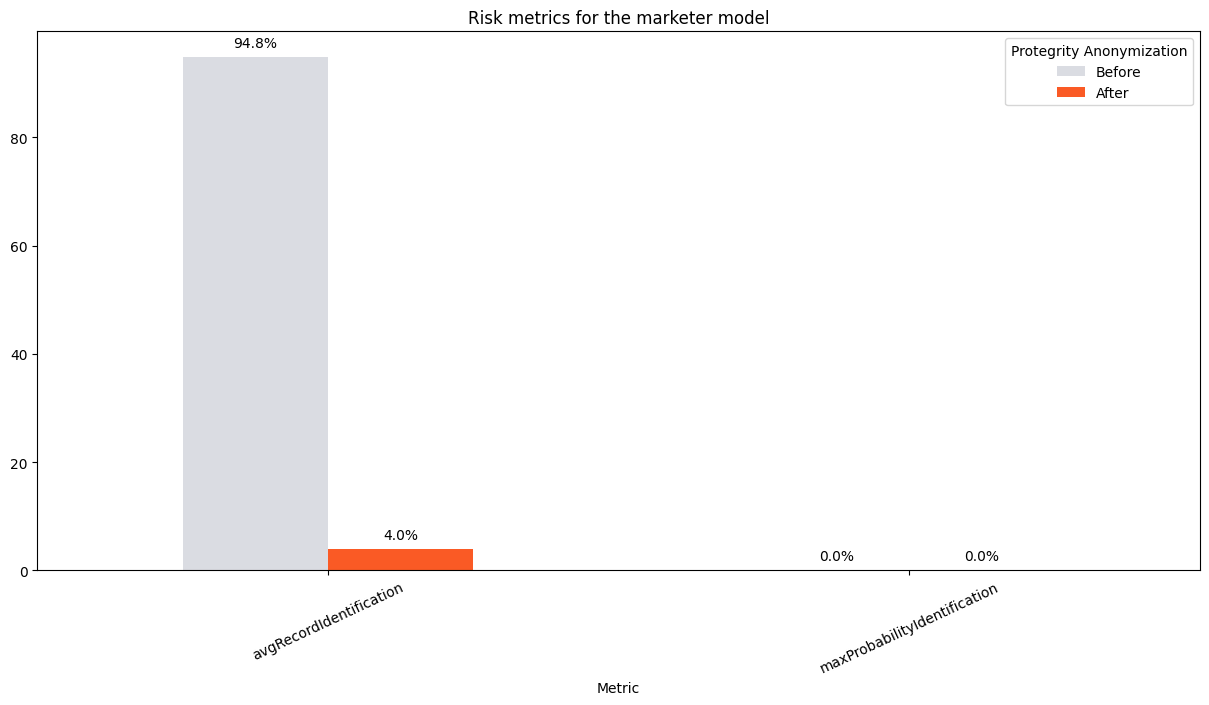

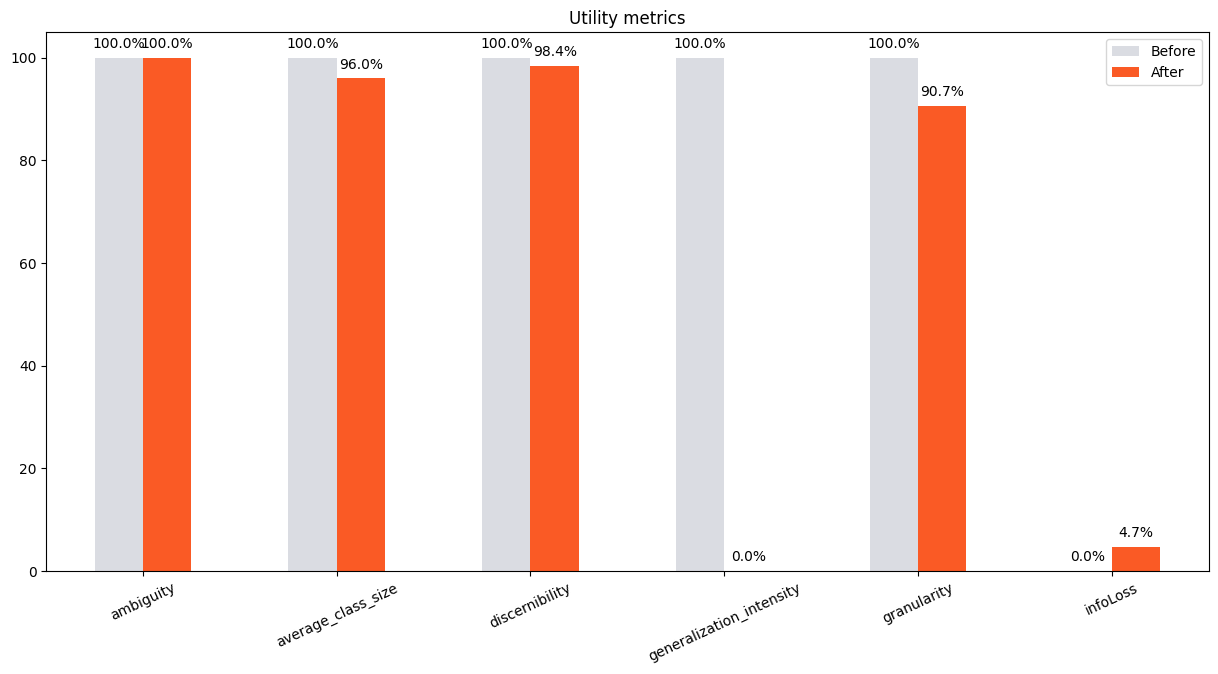

In [33]:
display_risk_utility(riskmetrics=job.riskStat().iloc[[0,1,3,4]], utilitymetrics=job.utilityStat())
